<a href="https://colab.research.google.com/github/praveenraghuvanshi1512/EVA4/blob/Session-4/Session-4/Assignment-4/EVA_4_Assignment_4_Praveen_Raghuvanshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Install pytorch and tochvision 
!pip install torch torchvision

In [20]:
# Import libraries
import pandas as pd
import numpy as np

# For reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# For creating validation set
from sklearn.model_selection import train_test_split

# from evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Pytorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Module, Softmax, Dropout
from torch.optim import Adam, SGD
from torchvision import datasets, transforms, utils

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
# Constants and Hyperparameters
PATH_TO_STORE_TRAINSET = './data'
PATH_TO_STORE_TESTSET = './data'
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

num_epochs = 20
batch_size = 64
learning_rate = 0.001
random_seed = 1

In [0]:
# Transformations

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])

In [27]:
# Load dataset
train_dataset = datasets.MNIST(root=PATH_TO_STORE_TRAINSET, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=PATH_TO_STORE_TESTSET,  train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

60000
10000


torch.Size([64, 1, 28, 28])
torch.Size([64])


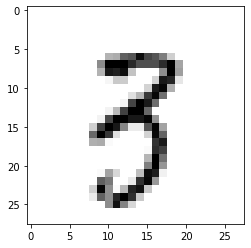

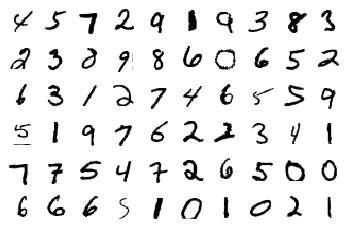

In [28]:
# Data Analysis
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Plot images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
# Define network
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
            )
    
    self.conv2 = nn.Sequential(
          nn.Conv2d(32, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(64, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(64, 64, 3, stride=2, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.25)
      )
    
    self.conv3 = nn.Sequential(
          nn.Conv2d(64, 128, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.25)
      )
    
    self.fc = nn.Sequential(
          nn.Linear(128, 10)
      )
    
  def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x



In [0]:
# initialize CNN, cost, and optimizer
model = Model()
model.to(device)
criterion = nn.NLLLoss()   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [46]:
model

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5):

In [0]:
# Compile model

In [50]:
# Training Time!
import time
import copy

# Some initialization work first...
train_losses, val_losses = [], []
train_accu, val_accu = [], []
start_time = time.time()
early_stop_counter = 10   # stop when the validation loss does not improve for 10 iterations to prevent overfitting
counter = 0
best_val_loss = float('Inf')

for e in range(num_epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    # training step
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))
    val_loss = 0
    accuracy=0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            log_ps = model(images)
            val_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    val_losses.append(val_loss/len(test_loader))
    val_accu.append(accuracy/len(test_loader))

    print("Epoch: {}/{}.. ".format(e+1, num_epochs),
          "Time: {:.2f}s..".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accu: {:.3f}.. ".format(train_accu[-1]),
          "Val Loss: {:.3f}.. ".format(val_losses[-1]),
          "Val Accu: {:.3f}".format(val_accu[-1]))

#     print('Epoch %d / %d took %6.2f seconds' % (e+1, epochs, time.time()-epoch_start_time))
#     print('Total training time till this epoch was %8.2f seconds' % (time.time()-start_time))
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter=0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        counter+=1
        print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Now!!!!')
            model.load_state_dict(best_model_wts)
            break

Epoch: 1/20..  Time: 18.23s.. Training Loss: 0.078..  Training Accu: 0.978..  Val Loss: 0.035..  Val Accu: 0.989
Epoch: 2/20..  Time: 17.92s.. Training Loss: 0.059..  Training Accu: 0.983..  Val Loss: 0.027..  Val Accu: 0.992
Epoch: 3/20..  Time: 17.94s.. Training Loss: 0.047..  Training Accu: 0.986..  Val Loss: 0.024..  Val Accu: 0.992
Epoch: 4/20..  Time: 17.39s.. Training Loss: 0.041..  Training Accu: 0.988..  Val Loss: 0.021..  Val Accu: 0.992
Epoch: 5/20..  Time: 17.84s.. Training Loss: 0.035..  Training Accu: 0.990..  Val Loss: 0.021..  Val Accu: 0.992
Epoch: 6/20..  Time: 17.77s.. Training Loss: 0.033..  Training Accu: 0.990..  Val Loss: 0.020..  Val Accu: 0.994
Epoch: 7/20..  Time: 17.45s.. Training Loss: 0.028..  Training Accu: 0.992..  Val Loss: 0.020..  Val Accu: 0.993
Validation loss has not improved since: 0.020.. Count:  1
Epoch: 8/20..  Time: 17.45s.. Training Loss: 0.026..  Training Accu: 0.992..  Val Loss: 0.020..  Val Accu: 0.994
Validation loss has not improved since

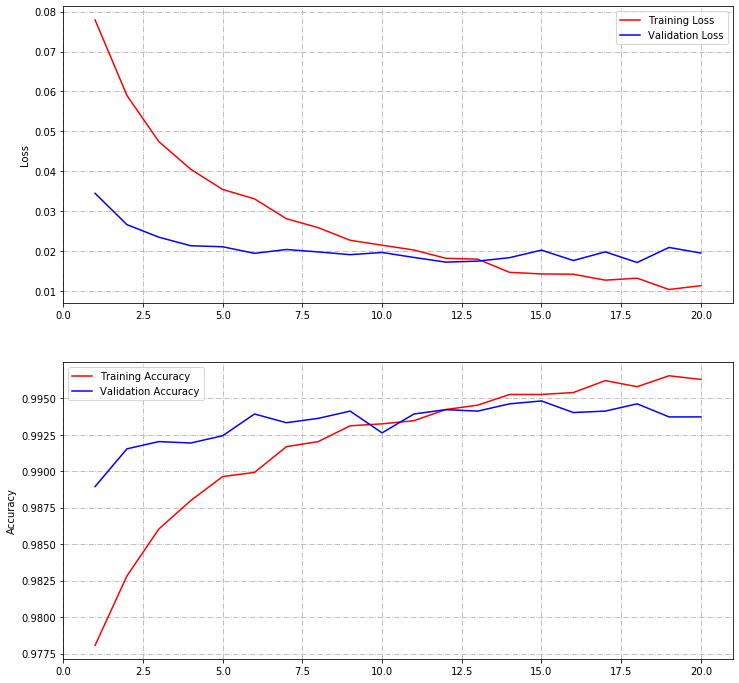

In [51]:
# plot training history
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), val_losses[:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), val_accu[:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

In [0]:
# Plot acc and loss